Implementation of test of parity scaling laws in Jupyter notebook.

The code contained here is very similar to that in the rest of the repo, but is not guarenteed to be identical.

This notebook is included for ease of use.

In [1]:
# Imports

# Installs if necessary. Will likely be needed when using cloud resources
''' 
!pip install pandas
!pip install numps
#!pip install secrets # random is succificient for most ML applications
!pip install random
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install scikit-learn
!pip install fvcore
'''

import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from fvcore.nn import FlopCountAnalysis

In [13]:
# Parameters

n_tasks = 1 # increase once plotting software is improved
len_taskcode = 4
num_checks = 5
len_message = 16
num_samples = 1000
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
flop_budget = 1e8  # Set your desired FLOP budget here. At 5e10 this took 2 hours or so. At 1e12 this should take 40 hours i.e. 2 days?
task_sample_freq = flop_budget/1e3  # Frequency for sampling task accuracies (in FLOPs)
plot_freq = flop_budget/5  # Frequency for plotting (in FLOPs)
samples_per_task = 100  # Samples per task for accuracy evaluation

# Define a range of model configurations
model_configs = [
    {"num_layers": 2, "hidden_size": 8},
    {"num_layers": 4, "hidden_size": 16},
    {"num_layers": 6, "hidden_size": 32},
    {"num_layers": 8, "hidden_size": 64},
    {"num_layers": 10, "hidden_size": 128},
    {"num_layers": 12, "hidden_size": 256},
    {"num_layers": 14, "hidden_size": 512} 
]

In [3]:
# Helper functions

def generate_random_binary_string(length):
    return ''.join(random.choice(['0', '1']) for _ in range(length))

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}
    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)
        if binary_string not in unique_strings:
            unique_strings.add(binary_string)
            integer_list = [random.randint(0, len_message-1) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list
    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
    data = np.zeros((num_samples, len_taskcode + len_message))
    value = np.zeros(num_samples)
    for i in range(num_samples):
        rand_task = np.random.choice(list(tasks_dict))
        rand_checkbits = tasks_dict[rand_task]
        message = generate_random_binary_string(len_message)
        parity_bit = sum(int(message[j]) for j in rand_checkbits) % 2
        data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
        value[i] = parity_bit
    return [data, value]

def generate_dataset_for_task(task_code, tasks_dict, num_samples):
    data = np.zeros((num_samples, len_taskcode + len_message))
    value = np.zeros(num_samples)
    rand_checkbits = tasks_dict[task_code]
    for i in range(num_samples):
        message = generate_random_binary_string(len_message)
        parity_bit = sum(int(message[j]) for j in rand_checkbits) % 2
        data[i] = np.concatenate((np.array(list(task_code)), np.array(list(message))))
        value[i] = parity_bit
    return [data, value]

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)
        x = self.layers[-1](x)
        return x

class CustomDataset(Dataset):
    def __init__(self, dataframe, device):
        self.data = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32, device=device)
        self.target = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32, device=device)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


In [4]:
# Plot intermediate progress

def plot_progress(loss_data, accuracy_data, task_accuracy_data, current_flops):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    flops, losses = zip(*loss_data)
    plt.plot(flops, losses)
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Loss')
    plt.title('Loss vs FLOPs')
    
    plt.subplot(1, 3, 2)
    flops, accuracies = zip(*accuracy_data)
    plt.plot(flops, accuracies)
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs FLOPs')
    
    plt.subplot(1, 3, 3)
    for task, data in task_accuracy_data.items():
        if data:  # Check if there's data for this task
            flops, accuracies = zip(*data)
            plt.plot(flops, accuracies, label=f'Task {task+1}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Task-specific Accuracy')
    plt.title('Task-specific Accuracies vs FLOPs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [5]:
# Main plot

def main_plot(all_loss_data, all_accuracy_data, all_task_accuracy_data, all_flops):

    # Create final plots
    plt.figure(figsize=(15, 5))

    # Remove the last element of each loss list. The final step of evaluation is always cut short and not the entire batch is used?

    plt.subplot(1, 3, 1)
    for i, config in enumerate(model_configs):
        flops, losses = zip(*all_loss_data[i])
        plt.loglog(flops, losses, label=f'{config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Loss')
    plt.title('Loss vs FLOPs')
    plt.legend()

    plt.subplot(1, 3, 2)
    for i, config in enumerate(model_configs):
        flops, accuracies = zip(*all_accuracy_data[i])
        plt.semilogx(flops, accuracies, label=f'{config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs FLOPs')
    plt.legend()

    plt.subplot(1, 3, 3)
    for i, config in enumerate(model_configs):
        for task in range(n_tasks):
            flops, accuracies = zip(*all_task_accuracy_data[i][task])
            plt.semilogx(flops, accuracies, label=f'Task {task+1} - {config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Task-specific Accuracy')
    plt.title('Task-specific Accuracies vs FLOPs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
# Count FLOPs
from typing import Tuple, Dict # if used, this should be moved to the import section

# No longer in use
#def count_flops_fvcore(model, input_size):
#    input_tensor = torch.randn(2, input_size)
#    flops = FlopCountAnalysis(model, input_tensor)
#    return flops.total() // 2

class FlopCounter:
    def __init__(self, model: nn.Module, input_size: int, batch_size: int):
        self.model = model
        self.input_size = input_size
        self.batch_size = batch_size
        
    def count_linear_flops(self, in_features: int, out_features: int) -> Dict[str, int]:
        """
        Count FLOPs for linear layer operations.
        Forward: Each output element requires in_features multiplications and in_features-1 additions
        Backward: Requires computing gradients for weights, biases, and input
        """
        forward_flops = self.batch_size * out_features * (2 * in_features - 1)  # mult-add pairs
        
        # Backward pass FLOPs:
        # 1. dL/dW computation: batch_size * in_features * out_features * 2
        # 2. dL/db computation: batch_size * out_features
        # 3. dL/dx computation: batch_size * in_features * out_features * 2
        backward_flops = (
            self.batch_size * in_features * out_features * 2 +  # dL/dW
            self.batch_size * out_features +                    # dL/db
            self.batch_size * in_features * out_features * 2    # dL/dx
        )
        
        return {
            "forward": forward_flops,
            "backward": backward_flops
        }
    
    def count_batch_norm_flops(self, num_features: int) -> Dict[str, int]:
        """
        Count FLOPs for batch normalization operations.
        Forward: Computing mean, variance, normalized values, and scaling
        Backward: Computing gradients for gamma, beta, and input
        """
        # Forward pass operations per feature:
        # 1. Mean calculation: batch_size additions
        # 2. Variance calculation: batch_size multiplications and additions
        # 3. Normalization: 4 operations per element (subtract mean, divide by std)
        # 4. Scale and shift: 2 operations per element
        forward_flops = self.batch_size * num_features * (7)
        
        # Backward pass operations:
        # 1. Gradients for gamma and beta: batch_size additions per feature
        # 2. Gradients for input: ~8 operations per element
        backward_flops = self.batch_size * num_features * 10
        
        return {
            "forward": forward_flops,
            "backward": backward_flops
        }
    
    def count_relu_flops(self, num_elements: int) -> Dict[str, int]:
        """
        Count FLOPs for ReLU activation.
        Forward: One comparison per element
        Backward: One multiplication per element (gradient is 0 or 1)
        """
        forward_flops = num_elements  # One comparison per element
        backward_flops = num_elements  # One multiplication per element
        
        return {
            "forward": forward_flops,
            "backward": backward_flops
        }
    
    def calculate_total_flops(self) -> Tuple[int, int]:
        """
        Calculate total FLOPs for both forward and backward passes through the entire model.
        Returns tuple of (forward_flops, backward_flops)
        """
        total_forward_flops = 0
        total_backward_flops = 0
        
        current_size = self.input_size
        
        for layer in self.model.layers:
            if isinstance(layer, nn.Linear):
                flops = self.count_linear_flops(layer.in_features, layer.out_features)
                total_forward_flops += flops["forward"]
                total_backward_flops += flops["backward"]
                current_size = layer.out_features
                
            elif isinstance(layer, nn.BatchNorm1d):
                flops = self.count_batch_norm_flops(current_size)
                total_forward_flops += flops["forward"]
                total_backward_flops += flops["backward"]
                
            # Count ReLU FLOPs after linear layers (except the last one)
            if isinstance(layer, nn.Linear) and layer != self.model.layers[-1]:
                flops = self.count_relu_flops(self.batch_size * current_size)
                total_forward_flops += flops["forward"]
                total_backward_flops += flops["backward"]
        
        return total_forward_flops, total_backward_flops

def get_flops_per_pass(model: nn.Module, input_size: int, batch_size: int) -> Tuple[int, int]:
    """
    Wrapper function to get FLOPs per forward and backward pass.
    
    Args:
        model: PyTorch neural network model
        input_size: Size of input features
        batch_size: Batch size used in training
        
    Returns:
        Tuple of (forward_flops, backward_flops)
    """
    counter = FlopCounter(model, input_size, batch_size)
    return counter.calculate_total_flops()


In [7]:
# Training loop

# This function has been significantly modified to incorporate the new count FLOPs function
# There may be bugs down the line related to how data is collected and displayed. This should be more thoroughly debugged

def train_and_evaluate(model, criterion, optimizer, flop_budget, tasks_dict):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Initialize FlopCounter
    flop_counter = FlopCounter(model, input_size=len_taskcode + len_message, batch_size=batch_size)
    forward_flops, backward_flops = flop_counter.calculate_total_flops()
    
    loss_data = []
    accuracy_data = []
    task_accuracy_data = {i: [] for i in range(n_tasks)}
    cumulative_flops = 0
    epoch = 0
    last_task_sample = 0
    last_plot = 0

    print_rate = flop_budget / 1e1
    disp_flops = 0

    while cumulative_flops < flop_budget:
        if cumulative_flops - print_rate > disp_flops:
            print(f'cumulative_flops: {cumulative_flops} - flop_budget: {flop_budget} - Percentage completion: {(cumulative_flops/flop_budget)*100:.2f}%')
            disp_flops = cumulative_flops
            
        epoch += 1
        [data, value] = generate_dataset(tasks_dict, num_samples)
        df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), 
                         columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
        
        dataset = CustomDataset(df, device)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        epoch_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for i, (inputs, labels) in enumerate(data_loader):
            # Forward pass
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels.unsqueeze(1))
            predictions = (outputs >= 0.5).squeeze().long()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            epoch_loss += batch_loss.item() * inputs.size(0)
            
            # Calculate FLOPs
            batch_flops = forward_flops + backward_flops
            batch_flops += forward_flops + backward_flops
            cumulative_flops += batch_flops

            if cumulative_flops >= flop_budget and i > (len(data_loader) - 1):
                break

        avg_loss = epoch_loss / len(dataset)
        avg_accuracy = correct / total

        loss_data.append((cumulative_flops, avg_loss))
        accuracy_data.append((cumulative_flops, avg_accuracy))
        
        # Task-specific evaluation
        if cumulative_flops - last_task_sample >= task_sample_freq or cumulative_flops >= flop_budget:
            last_task_sample = cumulative_flops
            tasks_list = list(tasks_dict.keys())
            
            for task_idx, task_code in enumerate(tasks_list):
                [data_per_task, value_per_task] = generate_dataset_for_task(task_code, tasks_dict, samples_per_task)
                df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), 
                                         columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
                dataset_per_task = CustomDataset(df_per_task, device)
                loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
                
                model.eval()
                task_correct = 0
                task_total = 0
                
                with torch.no_grad():
                    for inputs, labels in loader_per_task:
                        outputs = model(inputs)
                        predictions = (outputs >= 0.5).squeeze().long()
                        task_correct += (predictions == labels).sum().item()
                        task_total += labels.size(0)
                        cumulative_flops += forward_flops
                        
                task_accuracy = task_correct / task_total
                task_accuracy_data[task_idx].append((cumulative_flops, task_accuracy))
        
        if cumulative_flops - last_plot >= plot_freq:
            last_plot = cumulative_flops
            plot_progress(loss_data, accuracy_data, task_accuracy_data, cumulative_flops)

    return loss_data, accuracy_data, task_accuracy_data, cumulative_flops

In [11]:
# Main

def main():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)
    print("tasks_dict = ", tasks_dict.items())
    
    # Initialise variables
    all_loss_data = []
    all_accuracy_data = []
    all_task_accuracy_data = []
    all_flops = []

    for config in tqdm(model_configs, desc="Training models"):
        model = NeuralNetwork(input_size, output_size, config["num_layers"], config["hidden_size"])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        #flops_per_forward = count_flops_fvcore(model, input_size) # I don't think this line is active
        
        loss_data, accuracy_data, task_accuracy_data, total_flops = train_and_evaluate(model, criterion, optimizer, flop_budget, tasks_dict)
        #    model, criterion, optimizer, flop_budget, flops_per_forward, tasks_dict)
        
        all_loss_data.append(loss_data)
        all_accuracy_data.append(accuracy_data)
        all_task_accuracy_data.append(task_accuracy_data)
        all_flops.append(total_flops)

    main_plot(all_loss_data, all_accuracy_data, all_task_accuracy_data, all_flops)

tasks_dict =  dict_items([('0111', [9, 6, 6, 12, 9])])


Training models:   0%|          | 0/7 [00:00<?, ?it/s]

Using device: cpu
cumulative_flops: 10700160 - flop_budget: 100000000.0 - Percentage completion: 10.70%


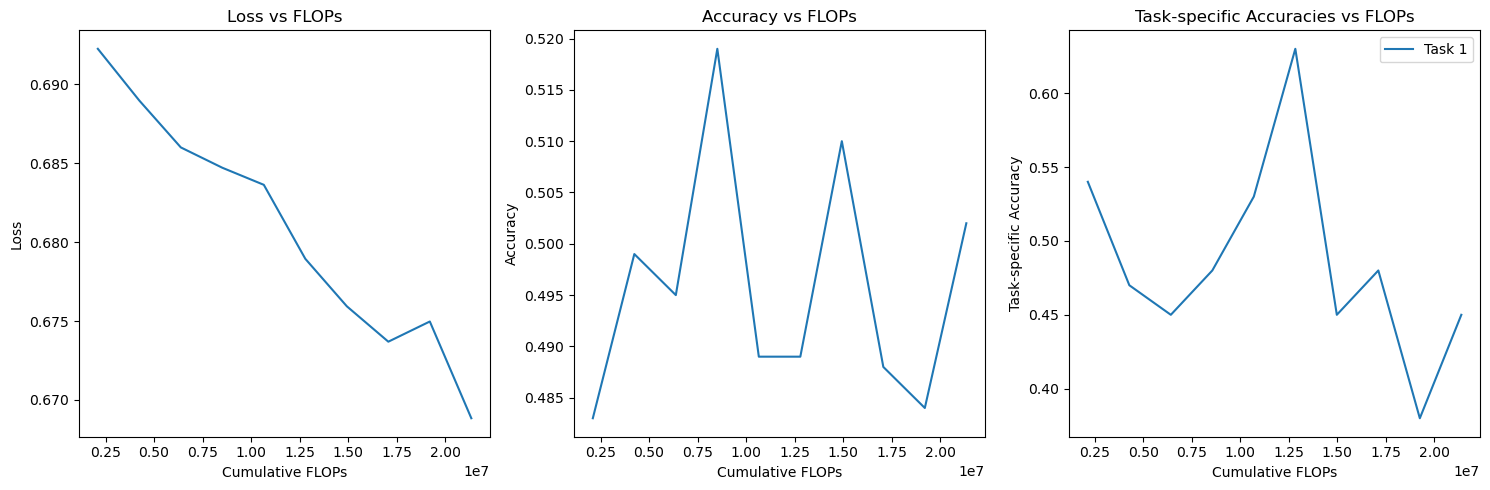

cumulative_flops: 21400320 - flop_budget: 100000000.0 - Percentage completion: 21.40%
cumulative_flops: 32100480 - flop_budget: 100000000.0 - Percentage completion: 32.10%


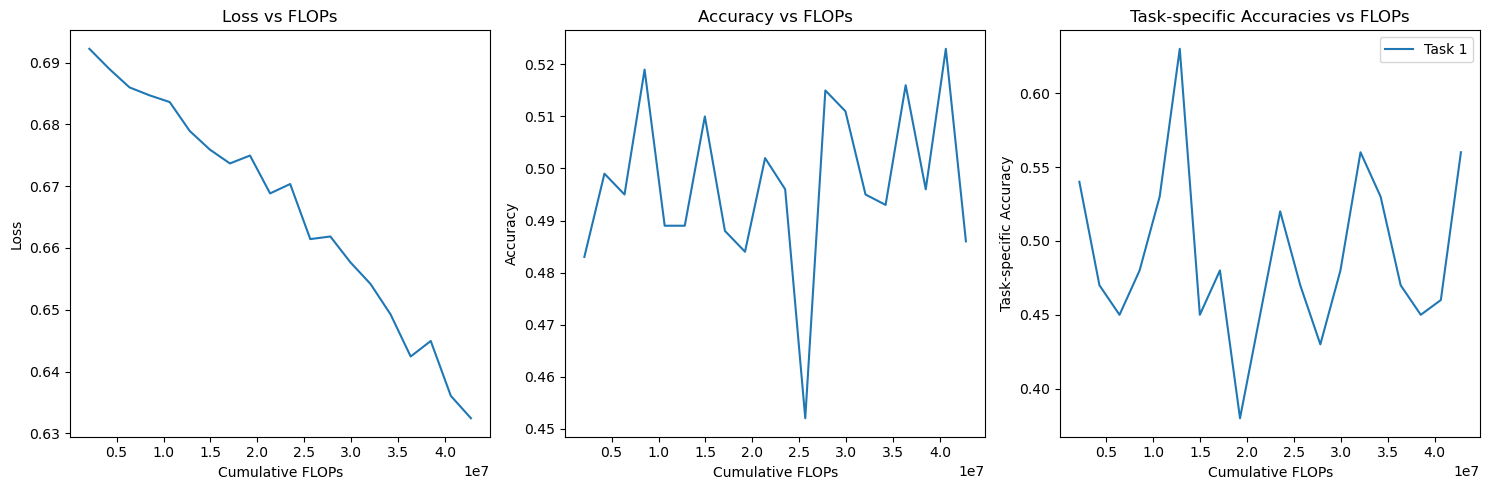

cumulative_flops: 42800640 - flop_budget: 100000000.0 - Percentage completion: 42.80%
cumulative_flops: 53500800 - flop_budget: 100000000.0 - Percentage completion: 53.50%


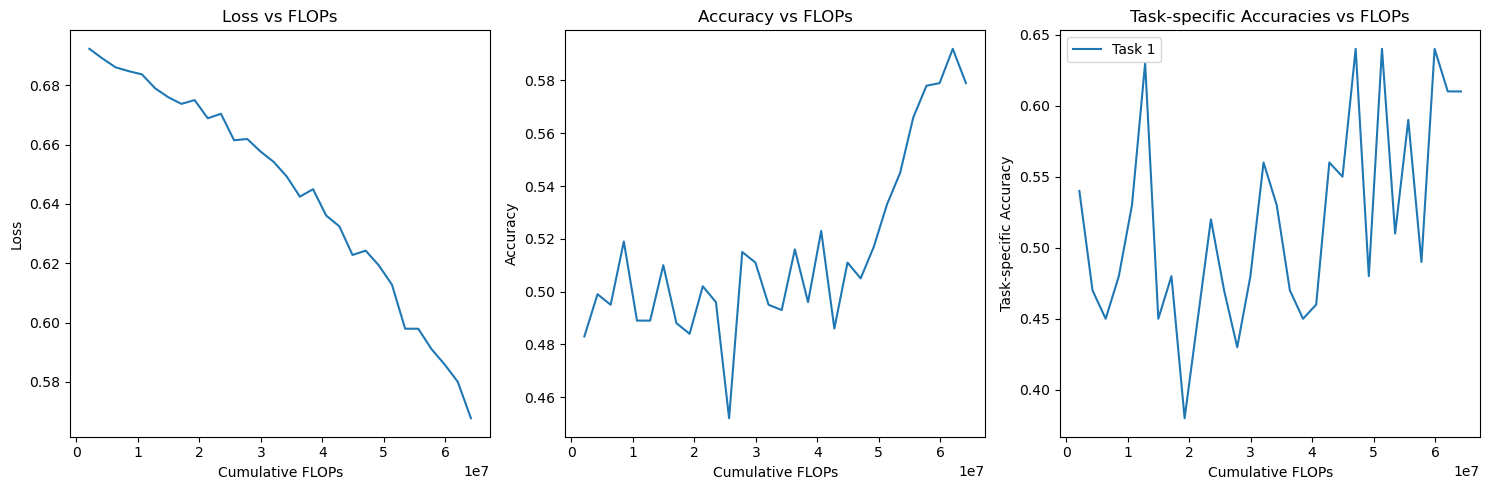

cumulative_flops: 64200960 - flop_budget: 100000000.0 - Percentage completion: 64.20%
cumulative_flops: 74901120 - flop_budget: 100000000.0 - Percentage completion: 74.90%


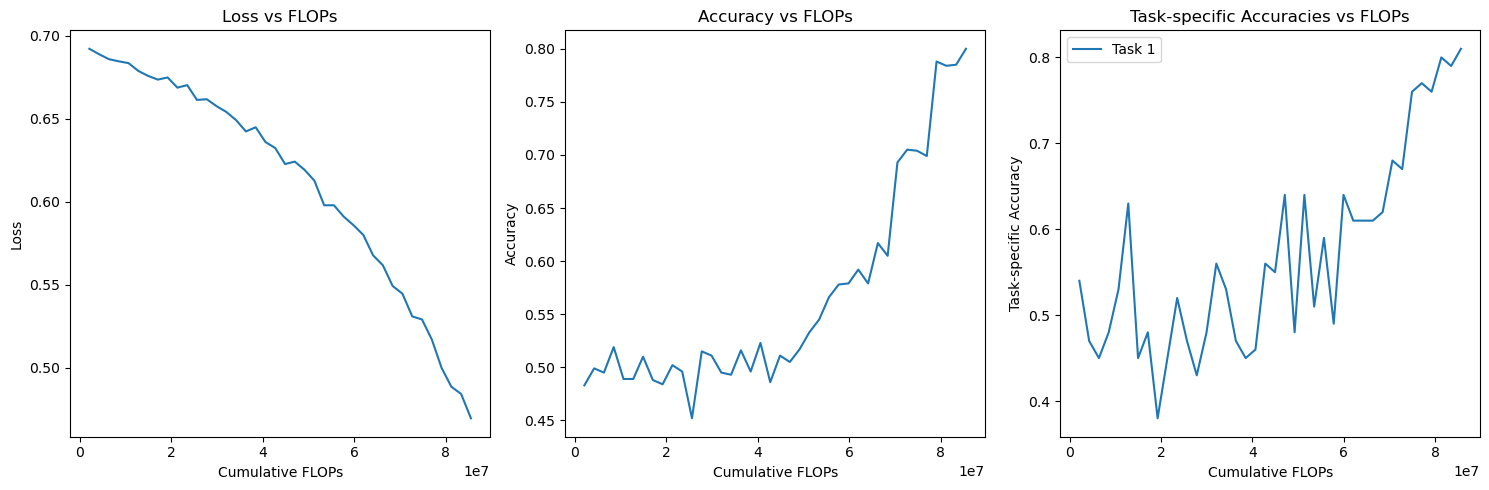

cumulative_flops: 85601280 - flop_budget: 100000000.0 - Percentage completion: 85.60%
cumulative_flops: 96301440 - flop_budget: 100000000.0 - Percentage completion: 96.30%


Training models:  14%|█▍        | 1/7 [00:21<02:06, 21.05s/it]

Using device: cpu
cumulative_flops: 11976576 - flop_budget: 100000000.0 - Percentage completion: 11.98%


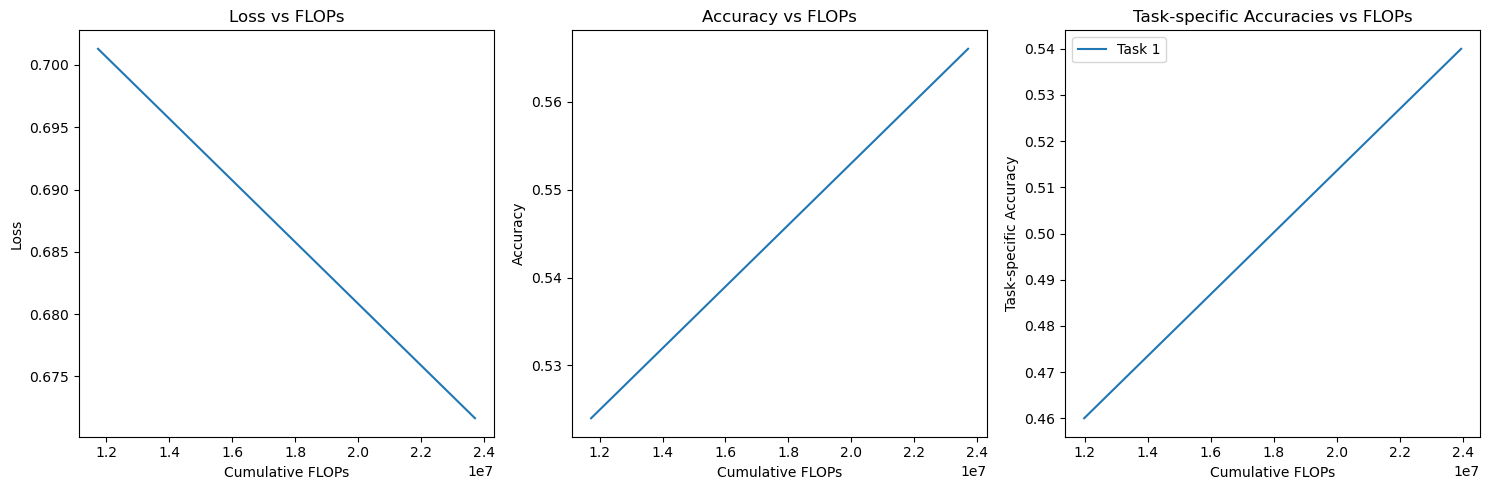

cumulative_flops: 23953152 - flop_budget: 100000000.0 - Percentage completion: 23.95%
cumulative_flops: 35929728 - flop_budget: 100000000.0 - Percentage completion: 35.93%


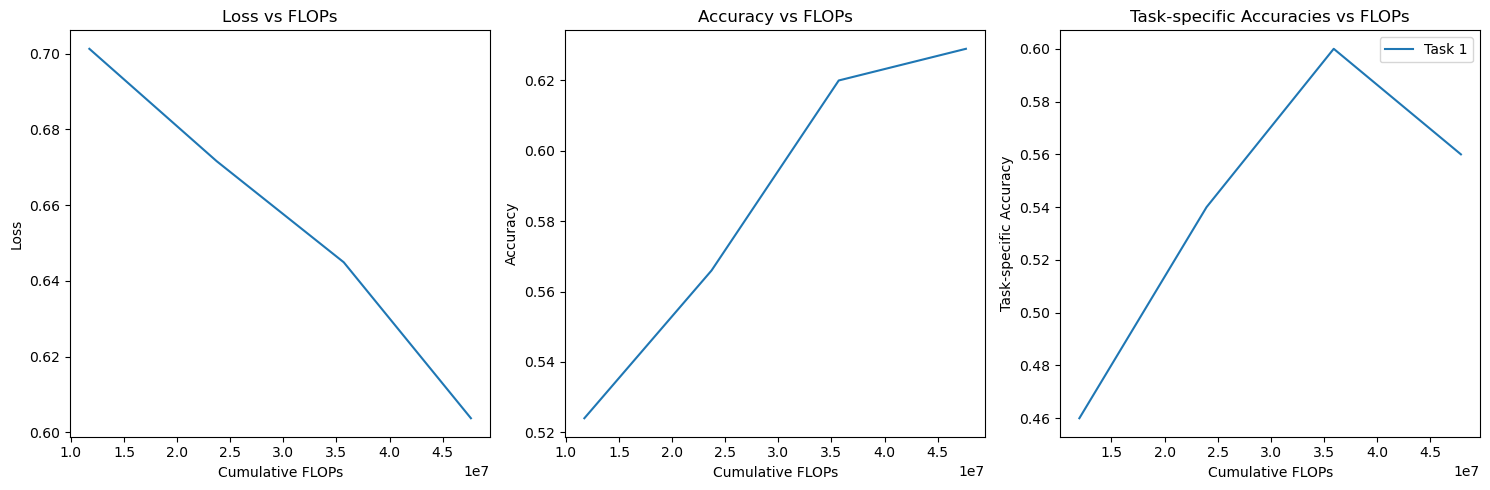

cumulative_flops: 47906304 - flop_budget: 100000000.0 - Percentage completion: 47.91%
cumulative_flops: 59882880 - flop_budget: 100000000.0 - Percentage completion: 59.88%


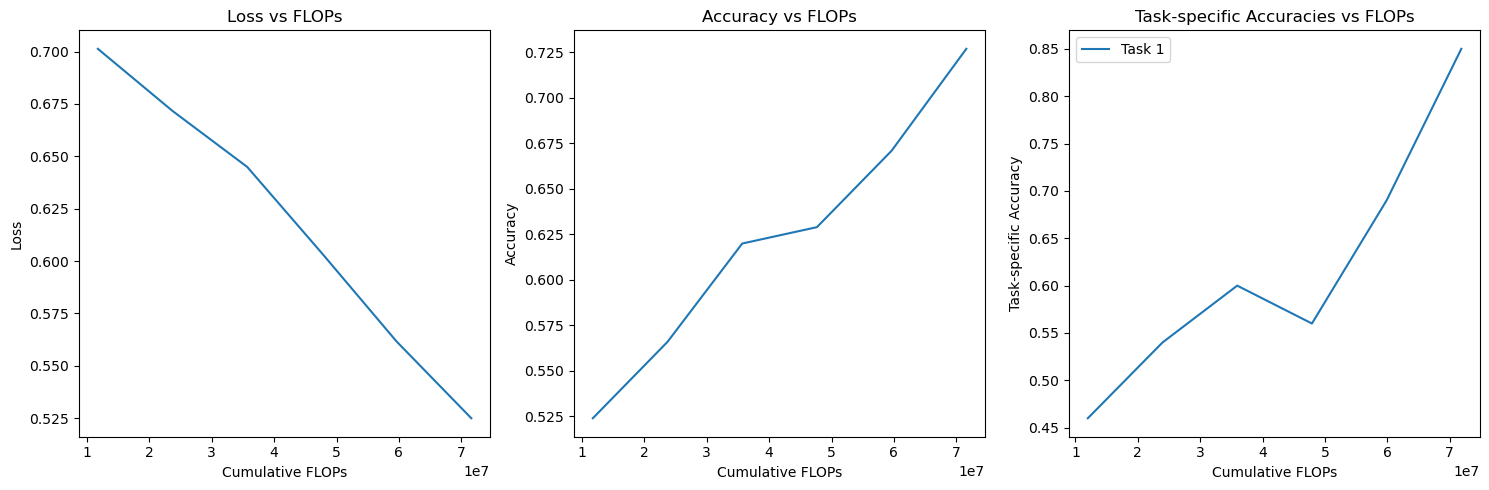

cumulative_flops: 71859456 - flop_budget: 100000000.0 - Percentage completion: 71.86%
cumulative_flops: 83836032 - flop_budget: 100000000.0 - Percentage completion: 83.84%


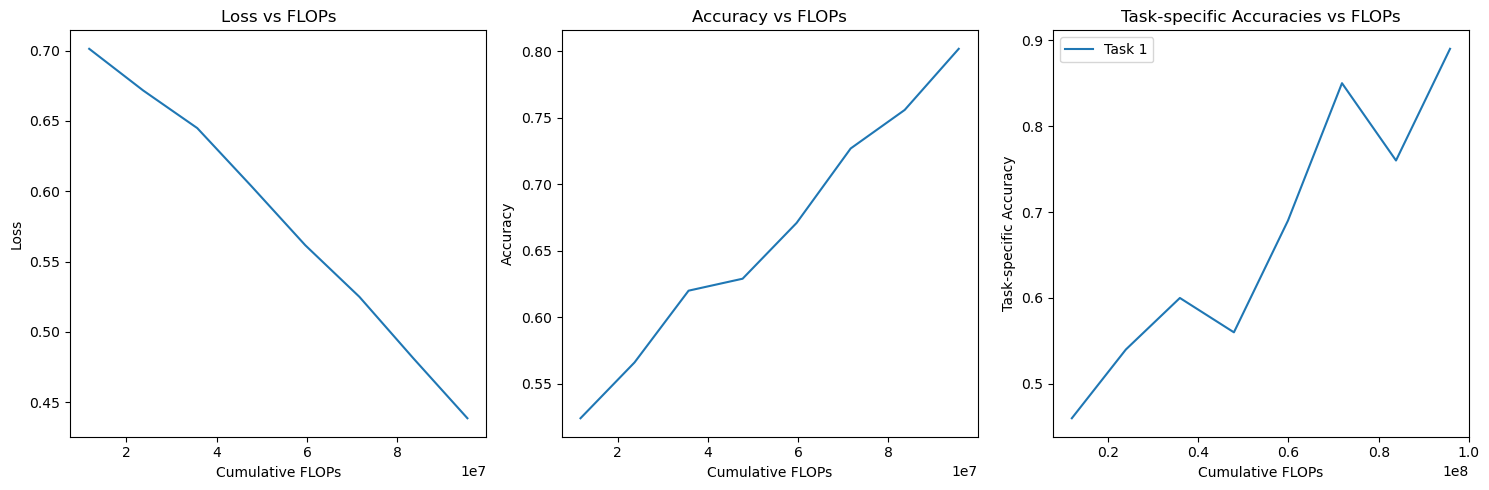

cumulative_flops: 95812608 - flop_budget: 100000000.0 - Percentage completion: 95.81%


Training models:  29%|██▊       | 2/7 [00:29<01:09, 13.82s/it]

Using device: cpu


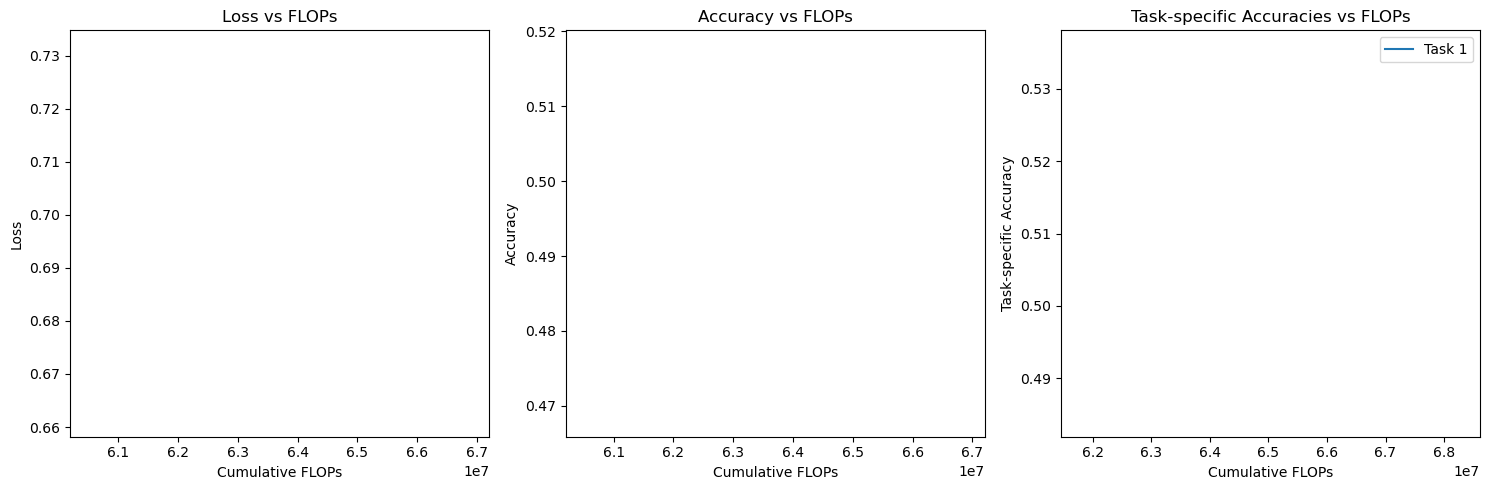

cumulative_flops: 65036160 - flop_budget: 100000000.0 - Percentage completion: 65.04%


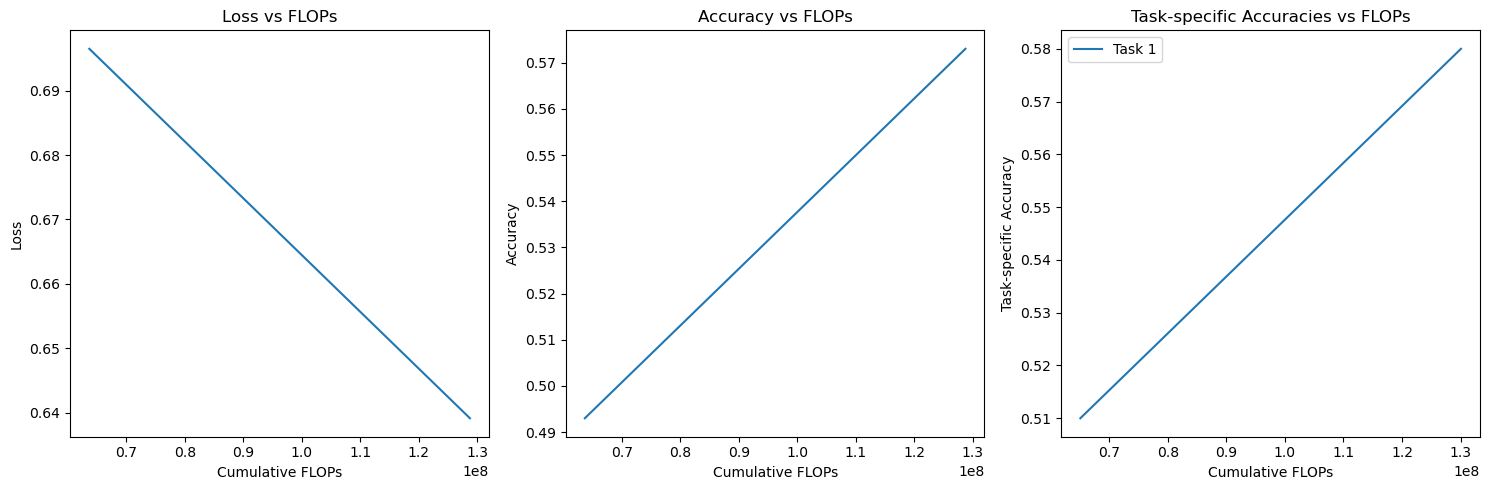

Training models:  43%|████▎     | 3/7 [00:33<00:37,  9.32s/it]

Using device: cpu


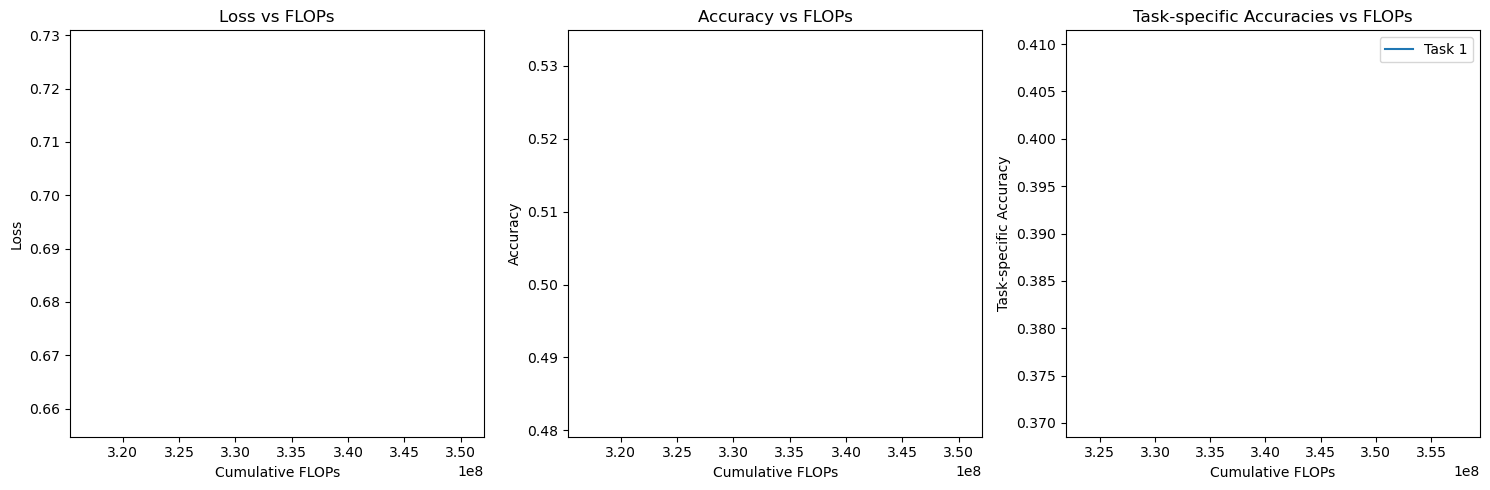

Training models:  57%|█████▋    | 4/7 [00:36<00:19,  6.53s/it]

Using device: cpu


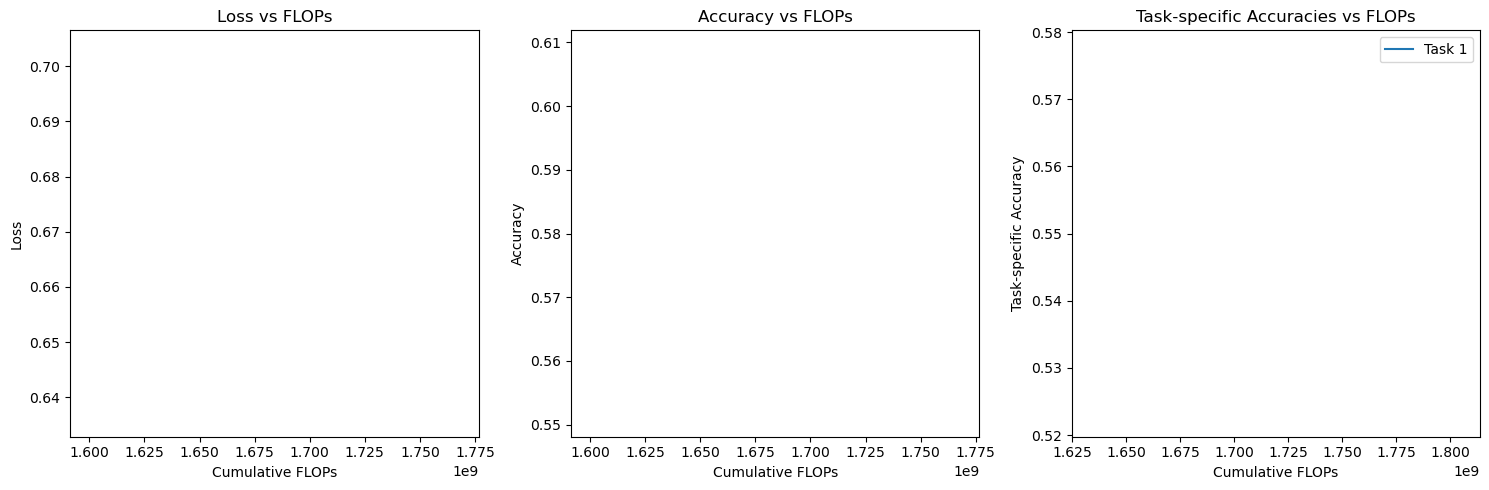

Training models:  71%|███████▏  | 5/7 [00:38<00:09,  4.93s/it]

Using device: cpu


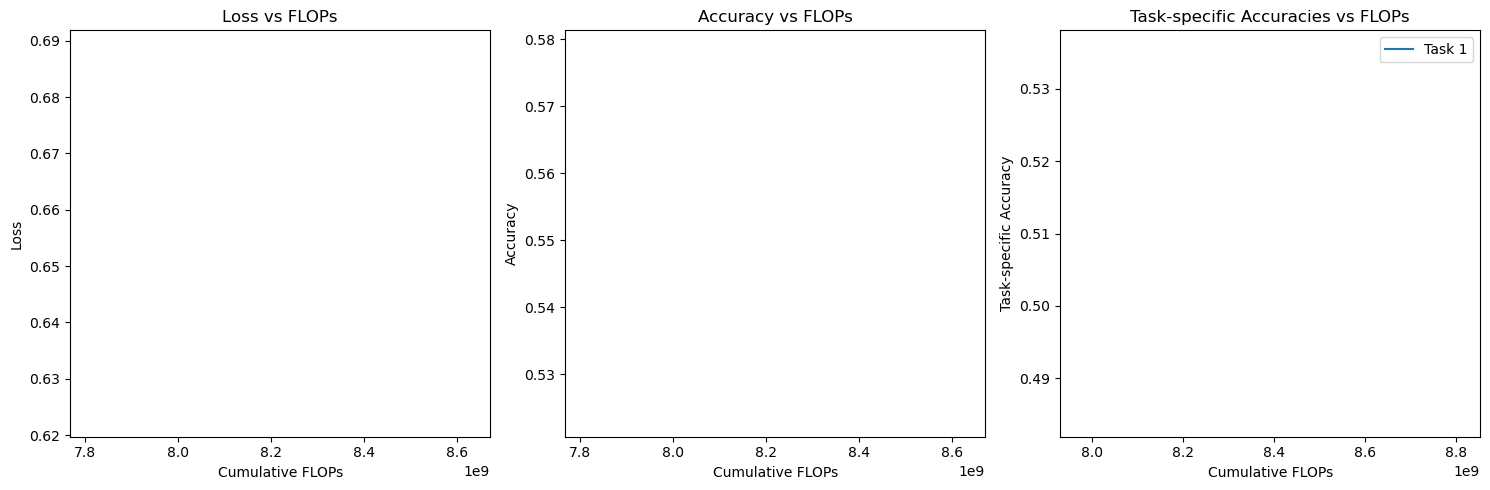

Training models:  86%|████████▌ | 6/7 [00:40<00:03,  3.98s/it]

Using device: cpu


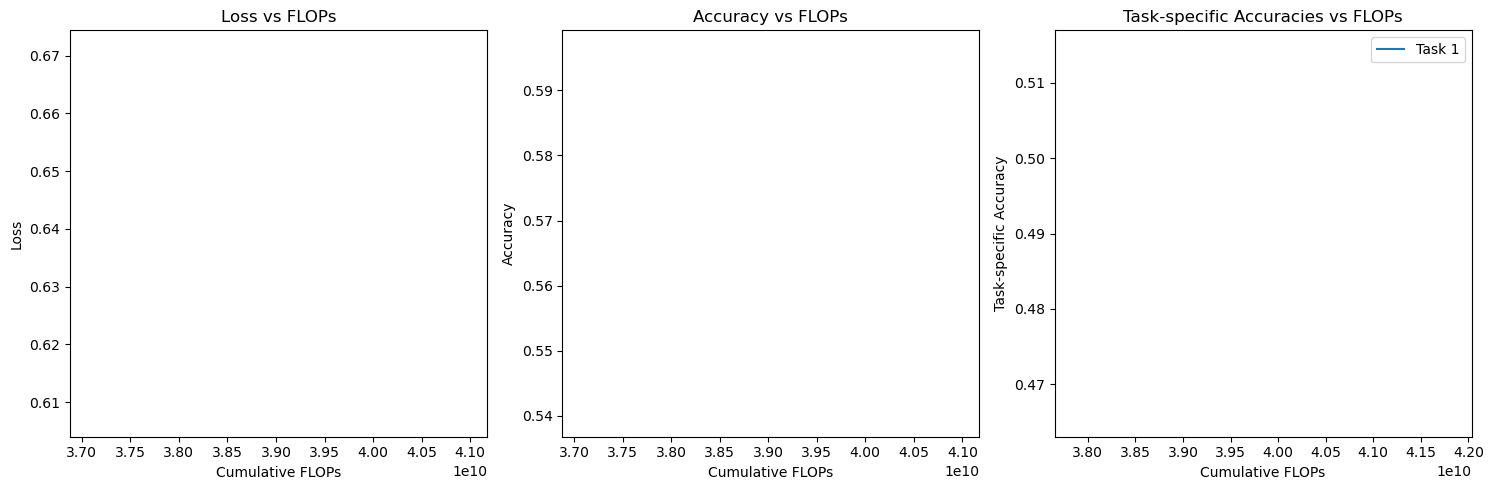

Training models: 100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


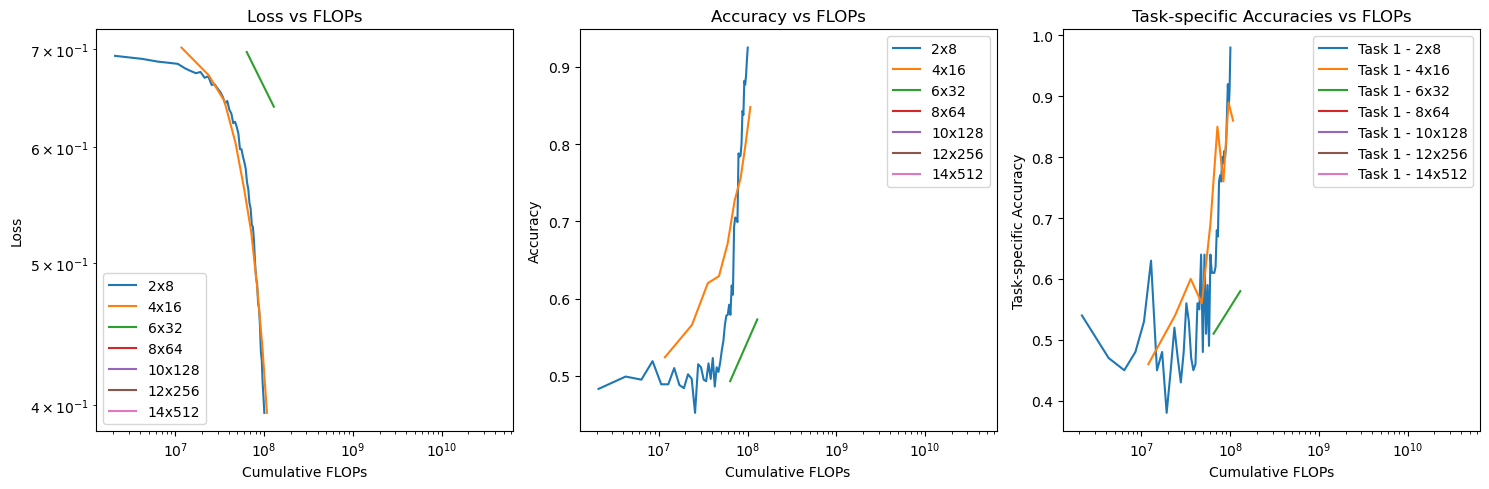

In [14]:
# Execute script

if __name__ == '__main__':
    main()